In [3]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import joblib

plt.style.use("seaborn-v0_8")

# --- 2. Load dataset WITH anomalies ---
df = pd.read_parquet("../../data/processed/air_12305_anomalies.parquet")

# --- 3. Create labels ---
# Label anomalies if at least 1 method flagged them
df['label'] = (df['anomaly_votes'] >= 1).astype(int)

print("Class distribution:")
print(df['label'].value_counts())

# --- 4. Features/labels ---
methods = ['anomaly_iforest','anomaly_ocsvm','anomaly_heuristic']
feature_cols = [c for c in df.columns if c not in ['time','id','is_running','label','anomaly_votes'] + methods]
X = df[feature_cols].fillna(0)
y = df['label']

# --- 5. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

# --- 6. Handle imbalance ---
pos = sum(y_train)
neg = len(y_train) - pos
scale = neg/pos if pos > 0 else 1
print(f"Training samples: {len(y_train)}, Anomalies: {pos}, Normals: {neg}")

# --- 7. Train XGBoost ---
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

# --- 8. Evaluate ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 9. Save model ---
model_out = "../../models/xgboost_12305.pkl"
joblib.dump(model, model_out)
print(f"✅ XGBoost model saved to {model_out}")


Class distribution:
label
0    526879
1     35045
Name: count, dtype: int64
Training samples: 393346, Anomalies: 24531, Normals: 368815

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    158064
           1       0.94      0.99      0.97     10514

    accuracy                           1.00    168578
   macro avg       0.97      0.99      0.98    168578
weighted avg       1.00      1.00      1.00    168578

Confusion Matrix:
 [[157455    609]
 [    65  10449]]
✅ XGBoost model saved to ../../models/xgboost_12305.pkl


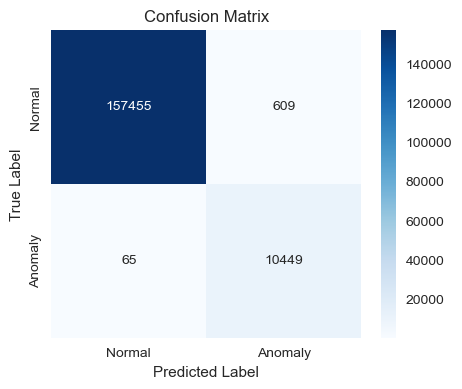

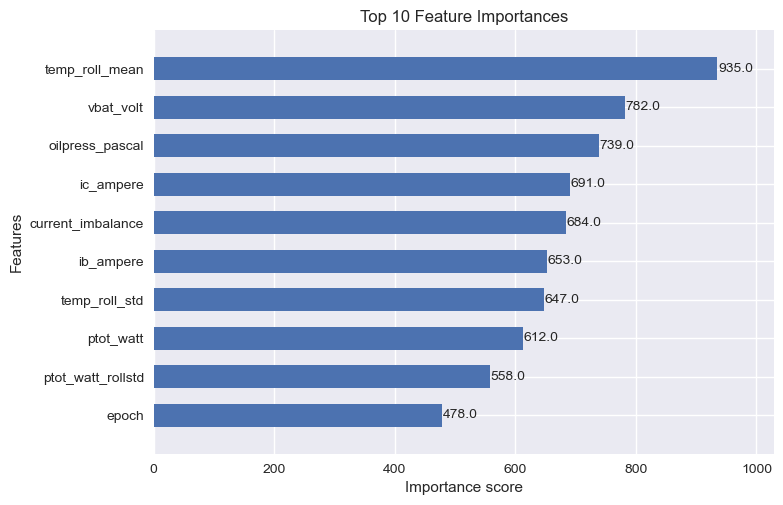

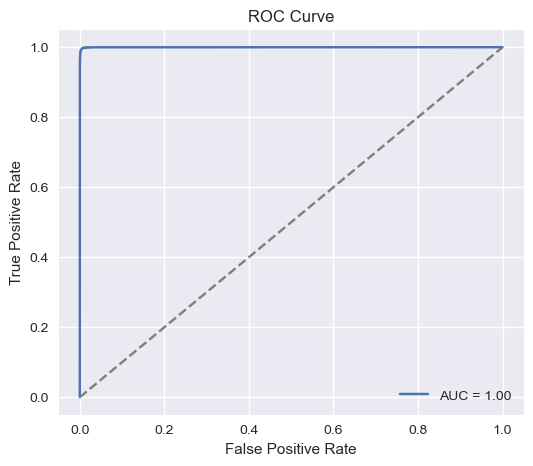

In [4]:
# --- 10. Plots ---

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Feature Importance
xgb.plot_importance(model, max_num_features=10, importance_type='weight', height=0.6)
plt.title("Top 10 Feature Importances")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
